In [1]:
import pandas as pd
import math as math
from numpy import sqrt
from numpy import asarray
from pandas import read_csv
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.special import boxcox, inv_boxcox

import numpy as np
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data = pd.read_csv("/Users/pattersonwu/Documents/apps/covidLSTM/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv");

In [3]:
china_data = data.loc[data['Country/Region'] == 'China'];

In [4]:
china_data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
154,Hubei,China,30.9756,112.2707,444,444,549,761,1058,1423,...,67786,67790,67794,67798,67799,67800,67800,67800,67800,67800
158,Guangdong,China,23.3417,113.4244,26,32,53,78,111,151,...,1356,1356,1360,1361,1364,1370,1378,1395,1400,1407
159,Henan,China,33.8820,113.6140,5,5,9,32,83,128,...,1273,1273,1273,1273,1273,1273,1273,1273,1273,1273
160,Zhejiang,China,29.1832,120.0934,10,27,43,62,104,128,...,1215,1227,1231,1231,1232,1232,1233,1234,1236,1237
161,Hunan,China,27.6104,111.7088,4,9,24,43,69,100,...,1018,1018,1018,1018,1018,1018,1018,1018,1018,1018


In [5]:
del china_data['Country/Region']

In [6]:
del china_data['Lat'];
del china_data['Long'];

In [7]:
china_data = china_data.melt(id_vars=['Province/State'], var_name='Date', value_name='Confirmed Cases');

In [8]:
china_data['Date'] = pd.to_datetime(china_data['Date']);
china_data_transformed = china_data.pivot(index='Date', columns='Province/State', values='Confirmed Cases');

In [9]:
del china_data_transformed['Tibet']
del china_data_transformed['Qinghai']

In [10]:
china_total = pd.DataFrame()
china_total['China Total Confirmed Cases'] = china_data_transformed.sum(axis=1)
china_total

,China Total Confirmed Cases
Date,
2020-01-22,548
2020-01-23,643
2020-01-24,920
2020-01-25,1405
2020-01-26,2074
...,...
2020-03-18,81083
2020-03-19,81137
2020-03-20,81231


In [11]:
# num_province = len(china_data_transformed.columns)

In [12]:
# running_average_by_province = pd.DataFrame();
# for x in range(num_province):
#     running_average_by_province[china_data_transformed.columns[x] + '_running_average'] = china_data_transformed[china_data_transformed.columns[x]].expanding(2).mean()

In [13]:
# ## Logarithmic transformationå
# china_total = np.log10(china_total)
# plt.plot(china_total)

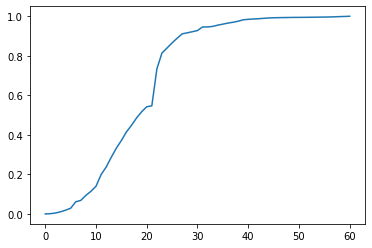

In [14]:
## Standardization
def normalizeData(data):
    scaler = MinMaxScaler().fit(data)
    data = scaler.transform(data)
    return data, scaler
china_total, scaler = normalizeData(china_total)
plt.plot(china_total)

In [15]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return asarray(X), asarray(y)

In [16]:
n_steps = 1
X, y = split_sequence(china_total, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [17]:
X.shape

(60, 1, 1)

In [18]:
print('Single input');
print(X[0])
print('Single output');
print(y[0])

Single input
[[0.]]
Single output
[0.00117531]


In [19]:
## Size of X
X.shape

(60, 1, 1)

In [20]:
## Splitting into validation and test sets
number_of_rows = X.shape[0]
n_train = math.ceil(number_of_rows*80/100)
n_test = n_train + math.floor(number_of_rows*10/100)
X_train, y_train, X_val, y_val, X_test, y_test = X[:n_train], y[:n_train], X[n_train:n_test], y[n_train:n_test], X[n_test:], y[n_test:]

In [22]:
tf.keras.backend.clear_session()
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=X_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])
opt = optimizers.Nadam(learning_rate=0.0001)
simple_lstm_model.compile(optimizer=opt, loss='mae', metrics=['mae', 'mse', 'msle'])
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
simple_lstm_model.fit(X_train, y_train, epochs=3000, batch_size=42, verbose=0,
                      validation_data=(X_val, y_val))

In [ ]:
simple_lstm_model.evaluate(X_test, y_test, verbose=2)

In [ ]:
## This is where we try to predict other country
korea_data = data.loc[data['Country/Region'] == 'Korea, South'];

In [ ]:
del korea_data['Lat']
del korea_data['Long']
del korea_data['Province/State']

In [ ]:
korea_data = korea_data.melt(id_vars=['Country/Region'], var_name='Date', value_name='Confirmed Cases');

In [ ]:
korea_data

In [ ]:
korea_data = korea_data.iloc[32:]

In [ ]:
korea_data['Date'] = pd.to_datetime(korea_data['Date']);

In [ ]:
korea_data = korea_data.pivot(index='Date', columns='Country/Region', values='Confirmed Cases');

In [ ]:
korea_data

In [ ]:
korea_total = pd.DataFrame()
korea_total['Korean Total Confirmed Cases'] = korea_data.sum(axis=1)

In [ ]:
korea_total, scaler = normalizeData(korea_total)

In [ ]:
X, y = split_sequence(korea_total, n_steps)

In [ ]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
y_hat = simple_lstm_model.predict(X)
## Gotta somehow convert this to dim of (49, 5, 1) where 5 = number of steps

In [ ]:
y = y.reshape(y.shape[0], 1)

In [ ]:
simple_lstm_model.evaluate(X, y, verbose=0)

In [ ]:
plt.plot(scaler.inverse_transform(y_hat))

In [ ]:
plt.plot(scaler.inverse_transform(y))

In [ ]:
scaler.inverse_transform(y_hat)-scaler.inverse_transform(y)

In [ ]:
plt.plot(scaler.inverse_transform(y_hat)-scaler.inverse_transform(y))